In [1]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import Pitch, Sbopen, VerticalPitch
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [11]:
parser  = Sbopen()
df, related, freeze, tactics = parser.event(3943043)
freeze ["player_name"].unique()
df.columns



Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_id', 'play_pattern_name',
       'team_id', 'team_name', 'tactics_formation', 'player_id', 'player_name',
       'position_id', 'position_name', 'pass_recipient_id',
       'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id',
       'pass_height_name', 'end_x', 'end_y', 'body_part_id', 'body_part_name',
       'sub_type_id', 'sub_type_name', 'x', 'y', 'outcome_id', 'outcome_name',
       'under_pressure', 'out', 'counterpress', 'pass_switch',
       'dribble_nutmeg', 'aerial_won', 'pass_cross', 'technique_id',
       'technique_name', 'pass_no_touch', 'foul_won_defensive', 'off_camera',
       'pass_assisted_shot_id', 'pass_shot_assist', 'shot_one_on_one',
       'shot_statsbomb_xg', 'shot_key_pass_id', 'goalkeeper_position_id',
       'goalkeeper_position_name', 'end_z',

In [3]:
name_replacements = {
    'Daniel Olmo Carvajal': 'Daniel Olmo',
    'Fabián Ruiz Peña': 'Fabián',
    'Lamine Yamal Nasraoui Ebana': 'Lamine Yamal',
    'Álvaro Borja Morata Martín': 'Álvaro Borja Morata',
    'Daniel Carvajal Ramos': 'Daniel Carvajal',
    'Rodrigo Hernández Cascante': 'Rodri',
    'Nicholas Williams Arthuer': 'N.Williams',
    'Marc Cucurella Saseta': 'Marc Cucurella',
    'Robin Aime Robert Le Normand': 'Robin Aime Robert LeNormand',
    'Unai Simón Mendibil': 'Unai Simón',
    'Martín Zubimendi Ibáñez': 'Martín Zubimendi ',
    'Mikel Oyarzabal Ugarte': 'Mikel Oyarzabal ',
    'Mikel Merino Zazón': 'Mikel Merino',
    'José Ignacio Fernández Iglesias': 'José Ignacio Fernández Iglesias'  }



df.replace(name_replacements, inplace=True)
related.replace(name_replacements, inplace=True)
freeze.replace(name_replacements, inplace=True)
tactics.replace(name_replacements, inplace=True)

In [4]:
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "Spain"].iloc[0]["index"]
mask_spain = (df.type_name == 'Pass') & (df.team_name == "Spain") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")
df_pass = df.loc[mask_spain, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

In [5]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player_name"].unique()):
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name
  
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]


scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [6]:
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
lines_df = lines_df[lines_df['pass_count']>2]


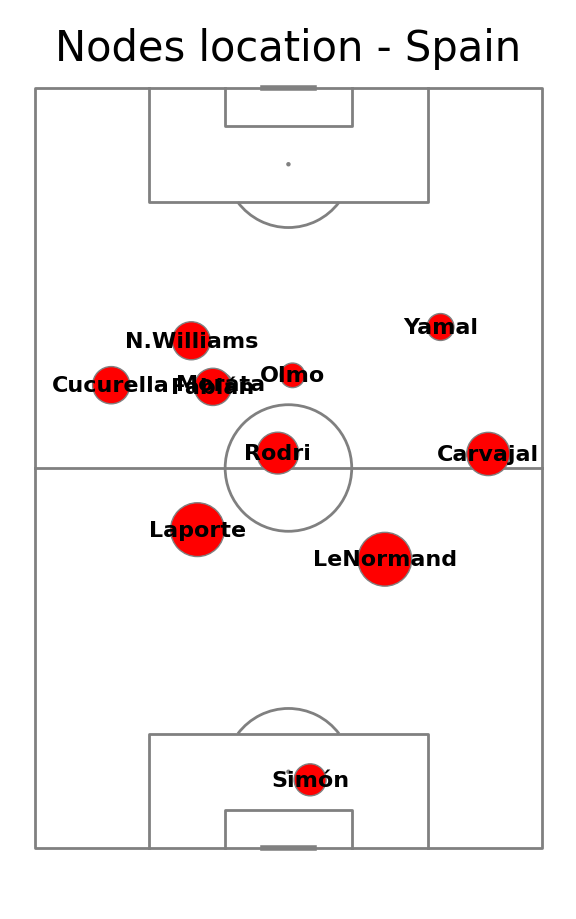

In [7]:
pitch = VerticalPitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

fig.suptitle("Nodes location - Spain", fontsize = 30)
plt.show()

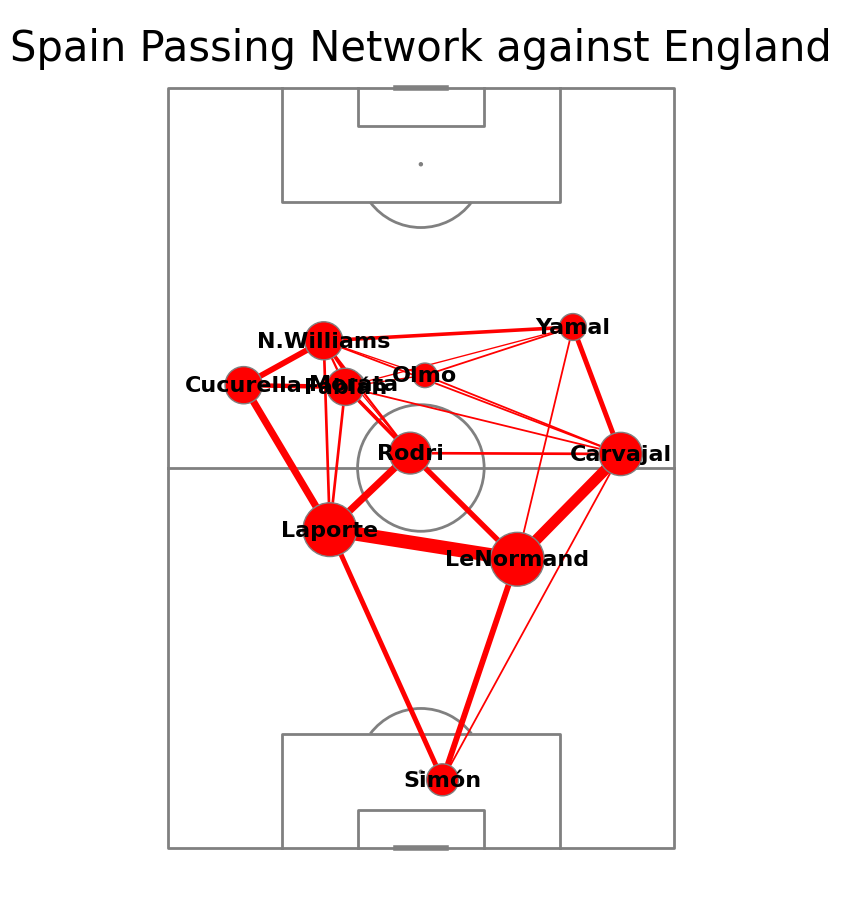

In [14]:
pitch = VerticalPitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
       
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
       
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="red", ax = ax["pitch"])

        


fig.suptitle("Spain Passing Network against England", fontsize = 30)
plt.show()

In [27]:
no_passes = df_pass.groupby(['player_name']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)

max_no = no_passes["pass_count"].max()
denominator = 10*no_passes["pass_count"].sum()
nominator = (max_no - no_passes["pass_count"]).sum()

centralisation_index = nominator/denominator
print("Centralisation index is ", centralisation_index)

Centralisation index is  0.09340659340659341
